# Decision Tree Algorithms for classification

This notebook develops and analyses algorithms for decision trees in classification tasks.The goal is to develop an understanding of the way these algorithms work in detail, so the emphasis is on understanding more than it is on computational efficiency.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Entropy calculation

In [4]:
# Calculating the entropy for one category
# Category proportion
def cat_prop(y,i):
    # y series, i sample
    # Calculate class proportion (instances of the i category divided by the total)
    return y.value_counts()[i] / len(y)

# Entropy formula (for one value)
def prob_entropy(p):
    if p == 0:
        return 0
    else:
        return -p*np.log2(p)

# Entropy formula (for each proportion)
def prop_entropy(y,i):
    prop = cat_prop(y,i)
    return prob_entropy(prop)

# Category entropy: receives a categoric variable column, returns its entropy
def cat_entropy(y):
    total = 0
    for i in y.unique():
        ent = prop_entropy(y,i)
        total += ent
    return total

# Conditional entropy summands
def entropy_sum(df,x,value,y):
    cond_y = df[(df[str(x)] == value)][y]
    prop_value = cat_prop(df[str(x)],value)
    return prop_value*cat_entropy(cond_y)

# Conditional entropy of the variable y partitioned by feature x
def cond_entropy(df,x,y):
    total = 0
    for i in df[str(x)].unique():
        total += entropy_sum(df,x,i,y)
    return total

# Information gain when partitioning variable y by feature x
def info_gain(df,x,y):
    # x and y are category names!!!
    return cat_entropy(df[str(y)]) - cond_entropy(df,x,y)

## Algorithm

### Full info version

In [293]:
# Recursive function
def id3_full(df,y):
    '''
    df: full pandas DataFrame
    y(string): name of the column to be taken as independent variable
    '''
    graph_list = []
    def id3_function(df,y,level=0):
        # Base case: is there a unique label for y? (no need to split further)
        if len(df[y].unique()) == 1:
            graph_list.append([level,'Leaf',df[y].unique()[0]])
        # Last feature left (return most repeated category)
        elif df.shape[1] == 2:
            X = df.drop(columns=[str(y)])
            for x in X.iloc[:,0].unique():
                listx = [level,'Leaf',str(X.columns[0])]
                cat_fr = df[df[X.columns[0]] == x][y].value_counts()
                ind_max = np.argmax(np.array(cat_fr)) # np.argmax returns the index
                guess = cat_fr.index[ind_max] # returns the actual category
                error_prob = 1 - (cat_fr[ind_max] / df[df[X.columns[0]] == x][y].shape[0])
                samples = df[df[X.columns[0]] == x][y].value_counts().sum()
                listx.extend([x,guess,'Samples: '+str(samples),'Prediction error: '+str(round(error_prob,4))])
                graph_list.append(listx)
        # Tree recursion
        else:
            X = df.drop(columns=[str(y)])
            # Choose the best feature for partition: construct info gain vector, select max
            gain_list =[]
            for i in range(X.shape[1]):
                # Reexpressing our data to fit the info_gain function definition
                gain_list.append(info_gain(df,X.columns[i],y))
            sel_index = np.argmax(gain_list)
            sel_feat = X.columns[sel_index]
            for x in df[sel_feat].unique():
                data = [level,'Branch',sel_feat,x,'Features left: '+str(df.shape[1]-2),'Info gain: '+str(round(gain_list[sel_index],4))]
                graph_list.append(data)
                id3_function(df[df[sel_feat] == str(x)].drop(columns=[sel_feat]),y,level=level+1)                
    id3_function(df,y)
    return graph_list

### Simplified version

In [138]:
def id3_train(df,y):
    detail = id3_full(df,y)
    result = []
    for x in detail:
        x_result = []
        for z in x:
            if not str(z).startswith(('Features left: ','Info gain: ','Samples: ','Prediction error: ')):
                x_result.append(z)
        result.append(x_result)
    return result

### Prediction

Of course, what good is a machine learning algorithm if it not useful to predict?

In [10]:
def id3_testpoint(df,y,point):
    results = id3_train(df,y)
    aux_list = []
    count = 0
    for i in range(len(results)):
        if (results[i][0] == count) and (point[results[i][2]] == results[i][3]):
            aux_list.append(results[i])
            count += 1
            if results[i][1] == 'Leaf':
                break
    for j in range(len(aux_list)):
        if aux_list[j][1] == 'Leaf':
            return aux_list[j][4]

In [9]:
def id3_test(df_train,y,df_test):
    df_reset = df_test.reset_index(drop=True)
    prediction = []
    for i in range(df_test.shape[0]):
        prediction.append(id3_testpoint(df_train,y,df_reset.iloc[i,:]))
    return prediction

## Working on the Titanic Dataset

In [142]:
df = sns.load_dataset('titanic')
dftit2 = df[['alive','sex','class']]
dftit2

,alive,sex,class
0,no,male,Third
1,yes,female,First
2,yes,female,Third
3,yes,female,First
4,no,male,Third
...,...,...,...
886,no,male,Second
887,yes,female,First
888,no,female,Third
889,yes,male,First


In [184]:
dftit[dftit['sex'] == 'male'].count()

survived       577
pclass         577
sex            577
age            453
sibsp          577
parch          577
fare           577
embarked       577
class          577
who            577
adult_male     577
deck           106
embark_town    577
alive          577
alone          577
dtype: int64

In [3]:
dftit3 = dftit.dropna(subset=['age'],axis=0)
conditions = [dftit3['age'] < 16]
values = ['child']
dftit3['age_group'] = np.select(conditions,['Child'],default='Adult')
dftit3 = dftit3[['alive','sex','class','age_group']]
dftit3

,alive,sex,class,age_group
0,no,male,Third,Adult
1,yes,female,First,Adult
2,yes,female,Third,Adult
3,yes,female,First,Adult
4,no,male,Third,Adult
...,...,...,...,...
885,no,female,Third,Adult
886,no,male,Second,Adult
887,yes,female,First,Adult
889,yes,male,First,Adult


In [294]:
ver = id3_alt(dftit3,'alive')
ver

[[0, 'Branch', 'sex', 'male'],
 [1, 'Branch', 'class', 'Third'],
 [2, 'Leaf', 'age_group', 'Adult', 'no'],
 [2, 'Leaf', 'age_group', 'Child', 'no'],
 [1, 'Branch', 'class', 'First'],
 [2, 'Leaf', 'age_group', 'Adult', 'no'],
 [2, 'Leaf', 'age_group', 'Child', 'yes'],
 [1, 'Branch', 'class', 'Second'],
 [2, 'Leaf', 'age_group', 'Adult', 'no'],
 [2, 'Leaf', 'age_group', 'Child', 'yes'],
 [0, 'Branch', 'sex', 'female'],
 [1, 'Branch', 'class', 'First'],
 [2, 'Leaf', 'age_group', 'Adult', 'yes'],
 [2, 'Leaf', 'age_group', 'Child', 'yes'],
 [1, 'Branch', 'class', 'Third'],
 [2, 'Leaf', 'age_group', 'Adult', 'no'],
 [2, 'Leaf', 'age_group', 'Child', 'yes'],
 [1, 'Branch', 'class', 'Second'],
 [2, 'Leaf', 'age_group', 'Child', 'yes'],
 [2, 'Leaf', 'age_group', 'Adult', 'yes']]

In [8]:
point1 = dftit3.iloc[650,:]
point2 = dftit3.iloc[153:170,:]
point3 = dftit3.iloc[350:400,:]

# Algorithm graph

In [365]:
from graphviz import Digraph
from IPython.display import Image

def create_branch(graph,parent,child,parent_label,child_label,edge_label):
    graph.node(child,label=child_label)
    graph.edge(parent,child,label=edge_label)
    
def ambig_leaf(graph,parent,child,label1,label2,prediction):
    graph.node(child)
    graph.node(prediction)
    graph.edge(parent,child,label=label1)
    graph.edge(child,prediction,label=label2)
    
def univ_leaf(graph,parent,child):
    graph.node(child)
    graph.edge(parent,child)

In [543]:
def create_graph(out):
    g = Digraph('letstry', filename='letsttry',
        node_attr={'shape': 'record','nodesep':'10.00'},format= 'png',graph_attr={'rankdir':'LR'})
    def graph_recur(g,out,level=0,parent_name=out[0][2]):
        level_list = []
        for i in range(0,len(out)):
            if out[i][0] == level:
                # Each tuple in level_list has: feature,index,category,branch/leaf
                level_list.append((out[i][2],i,out[i][3],out[i][1]))
        
        for j in range(len(level_list)):
            
            if level_list[j][3] == 'Leaf':
                g.attr('node', shape='ellipse')
                parent = parent_name # for node identification under recursion
                child = parent+level_list[j][2] # category-feature (parent-child)
                child_label = out[level_list[j][1]][4] # feature (child)
                edge_label = level_list[j][2] # category (parent)
                # Create branch with these variables
                g.node(child,label=child_label)
                g.edge(parent,child,label=edge_label)
                g.attr('node', shape='box')
            
            if level_list[j][3] == 'Branch':
                parent = parent_name # category-feature (grandparent-parent)
                child = parent+level_list[j][2]+'-'+out[level_list[j][1]+1][2] # category-feature (parent-child)
                child_label = out[level_list[j][1]+1][2] # feature (child)
                edge_label = level_list[j][2] # category (parent)
                # Create branch with these variables
                g.node(child,label=child_label)
                g.edge(parent,child,label=edge_label)
                # Short list for this branch: from one feature's category to the next
                if (j < len(level_list) - 1):
                    out_slice = out[level_list[j][1]:level_list[j+1][1]]
                else:
                    out_slice = out[level_list[j][1]:len(out)]
                # Recursion
                graph_recur(g,out_slice,level=level+1,parent_name=child)
                
    graph_recur(g,out)
    return g

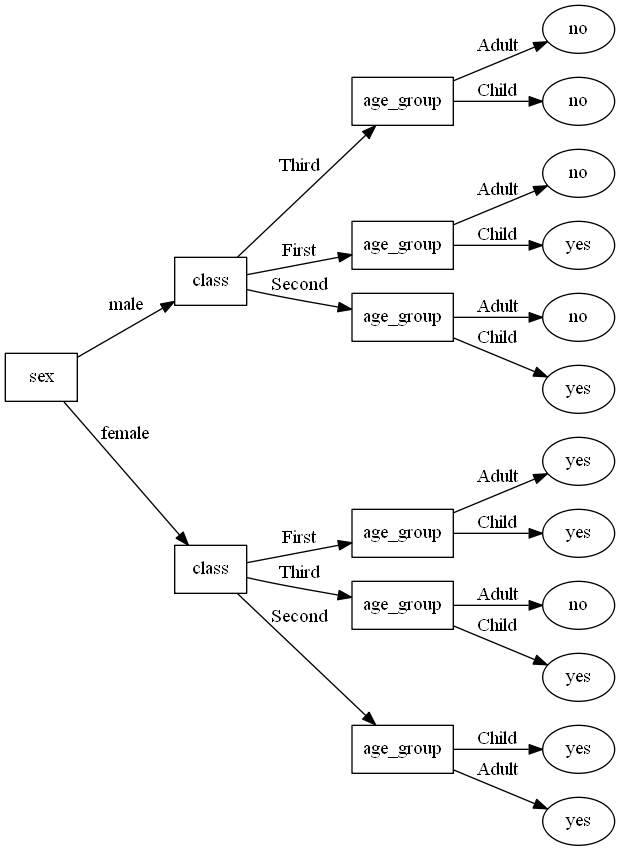

In [545]:
resu = create_graph(ver)
Image(resu.view())

## Grafico Matplotlib

In [291]:
# Generate a scatter plot
females = dftit2[dftit2['sex'] == 'female'].shape[0]
males = dftit2[dftit2['sex'] == 'male'].shape[0]
third = dftit2[dftit2['class'] == 'Third'].shape[0]
second = dftit2[dftit2['class'] == 'Second'].shape[0]
first = dftit2[dftit2['class'] == 'First'].shape[0]

x_fem = np.random.random(females)*2.6 + 0.2
x_male = np.random.random(males)*2.6 + 3.2
y_third = np.random.random(third)*1.7 + 0.15
y_sec = np.random.random(second)*1.7 + 2.15
y_first = np.random.random(first)*1.7 + 4.15

dftit2['x'] = 0
dftit2.sort_values(by='sex',inplace=True)
x_coord = np.concatenate((x_fem,x_male))
dftit2['x'] = x_coord

dftit2['y'] = 0
dftit2.sort_values(by='class',inplace=True)
y_coord = np.concatenate((y_first,y_sec,y_third))
dftit2['y'] = y_coord

# This will help in Matplotlib
dftit2['dummy'] = np.where(dftit2.alive == 'yes',1,0)

dftit2

,alive,sex,class,x,y,dummy
383,yes,female,First,2.488948,4.324275,1
275,yes,female,First,2.244972,4.878779,1
820,yes,female,First,0.204037,4.191240,1
457,yes,female,First,0.938858,4.781850,1
627,yes,female,First,2.272417,4.335222,1
...,...,...,...,...,...,...
715,no,male,Third,5.168449,0.916244,0
5,no,male,Third,3.393236,0.212823,0
873,no,male,Third,5.311678,0.401789,0
333,no,male,Third,3.813254,1.802178,0


In [331]:
# Import libraries, set general settings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


label = list(dftit2['dummy'])
colors = ['red','blue']
font_dictx = {'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline', 'horizontalalignment': 'left'}
font_dicty = {'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline', 'horizontalalignment': 'center'}
font_xaxis = {'fontsize': 35, 'fontweight': 'bold', 'verticalalignment': 'bottom', 'horizontalalignment': 'right'}

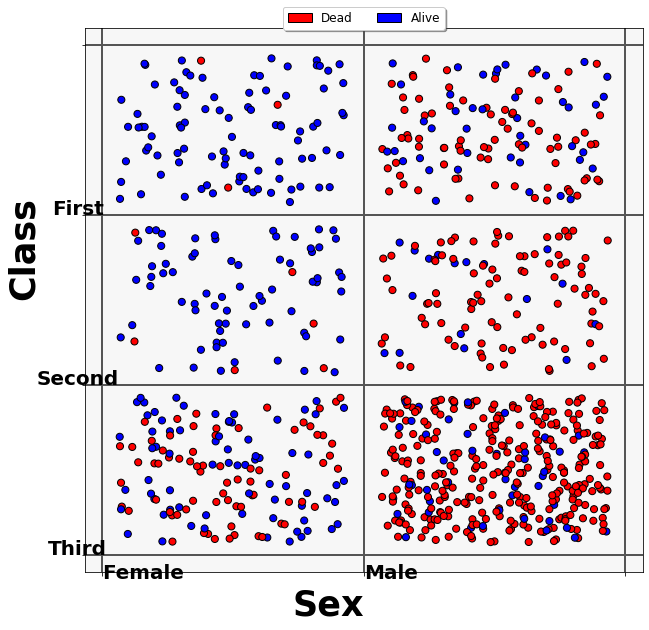

In [332]:
# Create plot
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(dftit2['x'], dftit2['y'],c=label, cmap=matplotlib.colors.ListedColormap(colors),edgecolors='#000000',s=50,linewidths=1)
plt.ylim(-0.2,6.2)
plt.xlim(-0.2,6.2)

# Background color
ax.set_facecolor((0.97,0.97,0.97))

# Grid
ax.grid(linewidth=2,color='#555555')
ax.set_yticks([0, 2, 4,6], minor=False)
ax.set_xticks([0, 3, 6], minor=False)
ax.yaxis.grid(True, which='major')

# Labels
label_colors = ['black','black']
ax.set_xticklabels(['Female','Male'],fontdict=font_dictx)
ax.set_yticklabels(['Third','Second','First'],fontdict=font_dicty)
plt.text(3,-0.8,'Sex',fontdict=font_xaxis,color=label_colors[0])
plt.text(-0.7,3,'Class',fontdict=font_xaxis,rotation=90,color=label_colors[1])

# Variable for blocking one side
hide=[0,0,0,0]

minxhide, maxxhide, minyhide, maxyhihidede = hide[0], hide[1], hide[2], hide[3]
plt.axvspan(hide[0], hide[1], ymin=hide[2], ymax=hide[3],facecolor='1.0', alpha=0.8,zorder=1)

# Variable for prediction color
pred_color = [0,0,0,0,0,0,0,0]

plt.axvspan(pred_color[0], pred_color[1], ymin=pred_color[2], ymax=pred_color[3],facecolor='blue', alpha=0.3,zorder=-1)
plt.axvspan(pred_color[4], pred_color[5], ymin=pred_color[6], ymax=pred_color[7],facecolor='red', alpha=0.3,zorder=-1)

# Variables for grid lines
xlines_list = []
ylines_list = []
for i in xlines_list:
    ax.get_xgridlines()[i].set_color('black')
    ax.get_xgridlines()[i].set_linewidth(12)
for j in ylines_list:
    ax.get_ygridlines()[j].set_color('black')
    ax.get_ygridlines()[j].set_linewidth(8)


alive_leg = mpatches.Patch(facecolor='red',edgecolor='black',label='Dead')
dead_leg = mpatches.Patch(facecolor='blue',edgecolor='black',label='Alive')
plt.legend(handles=[alive_leg,dead_leg],fontsize='large',loc='upper center',bbox_to_anchor=(0.5, 1.05),ncol=2,fancybox=True, shadow=True)

plt.show()

In [260]:
## MACHETE
# pred_color = [0,0,0.03,0.345,0,0,0,0,0] => bottom left
# pred_color = [0,0,0.345,0.66,0,0,0,0] => middle
# pred_color = [0,0,0.655,0.97,0,0,0,0] => top

# xlines_list = [1] => in the middle
# ylines_list = [0] => bottom